## 組合せ最適化問題
量子コンピュータで最適化問題を解くには、イジングモデルといわれる物理モデルを利用する。

## イジングモデルとQUBO
イジングモデルの問題は点（ノード）を線（エッジ）でつないで、点と線に値を設定して、点の+1もしくは-1を求めるような問題になっている。ただ、+1と-1だと私たちのコンピュータと相性が悪いので、通常は1と0を利用できるように値が変換された式を利用する。それをQUBO（キューボ）と呼ぶ。実際にはこのQUBOさえ作れれば問題は全部解くことができる。

QUBOは「エネルギー関数」や「コスト関数」もしくは「ハミルトニアン」と呼ばれ、問題設定を２次式の形で設定します。このコスト関数は小さいほうが正解になるように問題が設定されており、量子コンピュータや量子アニーラやその他準じるシミュレータはこの一番小さいコストを探す計算機となります。一番小さいコストを探すのは結構難しい問題です。

## QUBO定式化
QUBOは問題の答えが小さいほうが正解になるように設定された式です。式の形は、

$$
QUBO = -\sum_i h_i q_i -\sum_{i,j}J_{ij}q_iq_j
$$

となっている。iとjは点を表し、hはバイアス（局所磁場）、Jは相互作用と呼ばれます。この式ではqは量子ビットを表し0か1を取ります（イジングの場合は+1か-1）。
私たちはhとJを問題として設定し、qの値を求めます。

## 問題設定の仕方
問題の設定の仕方は、グラフ問題というものに問題を落とすことで計算できますが、いくつか問題を解くことでコツをつかめます。

主に問題のコスト関数は二種類の式を考える必要があります。

１．小さくしたいコスト関数  
２．満たすべき条件（制約条件）

この二つを別々に設計し、つなげることで実装できます。片方しかない式もあります。

## 問題設定の仕方2
問題設定としては点にかけるhはプラスの値をかけるとその点は0になりやすくなります。なぜなら1を取るとコストが大きくなるからです。逆にマイナスを書けると1になりやすくなります。線にかけるJはプラスをかけるとどちらか片方は0になりやすくなります。マイナスをかけると両方とも1になりやすくなります。このようにコストが小さくなるようにhやJを決めていきます。

## 使うツール
今回利用するツールを準備します。

networkx（ネットワークグラフを書く）  
matplotlib（各種のグラフを書く）  
numpy（数値ライブラリ）  

これらは、pipでインストールできます。

In [3]:
!pip install --quiet networkx matplotlib

## 1-1.maxcut問題
maxcut問題は一筆書きで切ることのできる最大の辺の数を求めるという問題です。問題設定としては、辺の両側の点の値が異なっていれば切れるという判定になります。

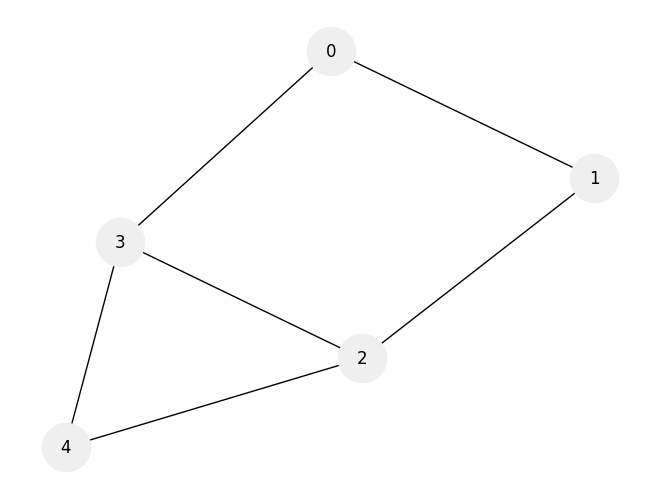

In [4]:
#ツールの読み込み
import networkx as nx
import matplotlib.pyplot as plt

#オプション。点のサイズ、点の番号の表示、色を調整。
options = {'node_size': 1200,'with_labels':'True','node_color':'#efefef'}

#初期化
G = nx.Graph()

#ノードを追加0,1,2,3,4のリストで追加。
G.add_nodes_from([0,1,2,3,4])

#エッジを追加
G.add_edges_from([(0,1),(0,3),(1,2),(2,3),(2,4),(3,4)])

#グラフを描く
nx.draw(G, **options)

maxcutのQUBO式は

$$
C = \sum_{i,j}(-q_i-q_j + 2q_iq_j)
$$

となります。もともとはイジングで隣り合う点が異なる符号を取る式は

$$
C = \sum_{i,j}x_ix_j
$$

から来ていて、それにQUBO変換の$x = 2q-1$を代入したものになっています。

元に戻って、上記のQUBO式に実際の値を入れてみます。頂点の登場回数とつながっているところだけを入れる必要がありますので、

$$
C = (-q_0-q_1+2q_0q_1) + (-q_1-q_2+2q_1q_2) + (-q_0-q_3+2q_0q_3) + (-q_2-q_3+2q_2q_3) + (-q_2-q_4+2q_2q_4) + (-q_3-q_4+2q_3q_4)
$$

同じ変数はまとめられます。

$$
C = -2q_0 -2q_1 -3q_2 -3q_3 -2q_4 +2q_0q_1 +2q_1q_2 +2q_0q_3 +2q_2q_3 +2q_2q_4 +2q_3q_4
$$

こちらの係数が大事になりますが、これをそのまま式に入れます。まずはpyquboで量子ビットを準備します。QUBOの場合にはvartypeにはBiNARYを選択します。

In [6]:
from tytan import *
import sympy as sym

# 変数を定義
q = sym.symbols("q_{0:5}")

そして上の式をそのまま入れます。

In [7]:
C = -2*q[0] -2*q[1] -3*q[2] -3*q[3] -2*q[4] +2*q[0]*q[1] +2*q[1]*q[2] +2*q[0]*q[3] +2*q[2]*q[3] +2*q[2]*q[4] +2*q[3]*q[4]
print(C)

2*q_{0}*q_{1} + 2*q_{0}*q_{3} - 2*q_{0} + 2*q_{1}*q_{2} - 2*q_{1} + 2*q_{2}*q_{3} + 2*q_{2}*q_{4} - 3*q_{2} + 2*q_{3}*q_{4} - 3*q_{3} - 2*q_{4}


定式化ができましたので、これをソルバー（精算してくれるプログラム）に入れます。Nealにいれるときに形式的にBQMというD-Wave専用の方式に変換します。

In [12]:
# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(C).get_qubo()

print(Q)

{('q_{2}', 'q_{2}'): -3, ('q_{3}', 'q_{3}'): -3, ('q_{0}', 'q_{0}'): -2, ('q_{1}', 'q_{1}'): -2, ('q_{4}', 'q_{4}'): -2, ('q_{0}', 'q_{1}'): 2, ('q_{0}', 'q_{3}'): 2, ('q_{1}', 'q_{2}'): 2, ('q_{2}', 'q_{3}'): 2, ('q_{2}', 'q_{4}'): 2, ('q_{3}', 'q_{4}'): 2}


ソルバーはSimualtedAnnealingSamplerを利用します。num_readsは100回計算します。計算結果は表形式で出ます。

In [13]:
# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)
print(result)

[[{'q_{0}': 0.0, 'q_{1}': 1.0, 'q_{2}': 0.0, 'q_{3}': 1.0, 'q_{4}': 0.0}, -5.0, 26], [{'q_{0}': 0.0, 'q_{1}': 1.0, 'q_{2}': 0.0, 'q_{3}': 1.0, 'q_{4}': 1.0}, -5.0, 21], [{'q_{0}': 1.0, 'q_{1}': 0.0, 'q_{2}': 1.0, 'q_{3}': 0.0, 'q_{4}': 0.0}, -5.0, 26], [{'q_{0}': 1.0, 'q_{1}': 0.0, 'q_{2}': 1.0, 'q_{3}': 0.0, 'q_{4}': 1.0}, -5.0, 27]]


そして、一番いい答えをエネルギーから選びます。

In [17]:
print("Sample =", result[0][0])
print("Cost =", result[0][1] + offset)

Sample = {'q_{0}': 0.0, 'q_{1}': 1.0, 'q_{2}': 0.0, 'q_{3}': 1.0, 'q_{4}': 0.0}
Cost = -5.0


以上です！

## 1-2. 自然数分割問題
自然数分割問題は自然数(0より大きい数)を二つのグループに分け、それぞれのグループの自然数の和が同じようになるようにする問題です。こちらのQUBOは、

$$
H = (\sum_i n_i*(2q_i-1))^2
$$

となります。元はイジングで、

$$
H = (\sum_i n_i*x_i)^2
$$

の式をQUBOに変換した形になります。

### 問題設定
[3,6,5,6,5,2,6,5]の配列（合計38）を二つに分けます。量子ビットは8用意します。

In [31]:
arr = [3,6,5,6,5,2,6,5]

# 変数を定義
q = sym.symbols("q_{0:8}")

C = 0
for i in range(8):
    C += arr[i]*(2*q[i]-1)
    
C = C**2
C = C.expand()
print(C)

#地道に書いてもOK
#C = (3*(2*q[0]-1) + 6*(2*q[1]-1) + 5*(2*q[2]-1) + 6*(2*q[3]-1) + 5*(2*q[4]-1) + 2*(2*q[5]-1) + 6*(2*q[6]-1) + 5*(2*q[7]-1))**2

#配列を部分的に使ってもOK
#C = (arr[0]*(2*q[0]-1) + arr[1]*(2*q[1]-1) + arr[2]*(2*q[2]-1) + arr[3]*(2*q[3]-1) + arr[4]*(2*q[4]-1) + arr[5]*(2*q[5]-1) + arr[6]*(2*q[6]-1) + arr[7]*(2*q[7]-1))**2

36*q_{0}**2 + 144*q_{0}*q_{1} + 120*q_{0}*q_{2} + 144*q_{0}*q_{3} + 120*q_{0}*q_{4} + 48*q_{0}*q_{5} + 144*q_{0}*q_{6} + 120*q_{0}*q_{7} - 456*q_{0} + 144*q_{1}**2 + 240*q_{1}*q_{2} + 288*q_{1}*q_{3} + 240*q_{1}*q_{4} + 96*q_{1}*q_{5} + 288*q_{1}*q_{6} + 240*q_{1}*q_{7} - 912*q_{1} + 100*q_{2}**2 + 240*q_{2}*q_{3} + 200*q_{2}*q_{4} + 80*q_{2}*q_{5} + 240*q_{2}*q_{6} + 200*q_{2}*q_{7} - 760*q_{2} + 144*q_{3}**2 + 240*q_{3}*q_{4} + 96*q_{3}*q_{5} + 288*q_{3}*q_{6} + 240*q_{3}*q_{7} - 912*q_{3} + 100*q_{4}**2 + 80*q_{4}*q_{5} + 240*q_{4}*q_{6} + 200*q_{4}*q_{7} - 760*q_{4} + 16*q_{5}**2 + 96*q_{5}*q_{6} + 80*q_{5}*q_{7} - 304*q_{5} + 144*q_{6}**2 + 240*q_{6}*q_{7} - 912*q_{6} + 100*q_{7}**2 - 760*q_{7} + 1444


In [33]:
# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(C).get_qubo()

print(Q)

# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)
print(result)

{('q_{1}', 'q_{1}'): -768, ('q_{3}', 'q_{3}'): -768, ('q_{6}', 'q_{6}'): -768, ('q_{2}', 'q_{2}'): -660, ('q_{4}', 'q_{4}'): -660, ('q_{7}', 'q_{7}'): -660, ('q_{0}', 'q_{0}'): -420, ('q_{5}', 'q_{5}'): -288, ('q_{0}', 'q_{5}'): 48, ('q_{2}', 'q_{5}'): 80, ('q_{4}', 'q_{5}'): 80, ('q_{5}', 'q_{7}'): 80, ('q_{1}', 'q_{5}'): 96, ('q_{3}', 'q_{5}'): 96, ('q_{5}', 'q_{6}'): 96, ('q_{0}', 'q_{2}'): 120, ('q_{0}', 'q_{4}'): 120, ('q_{0}', 'q_{7}'): 120, ('q_{0}', 'q_{1}'): 144, ('q_{0}', 'q_{3}'): 144, ('q_{0}', 'q_{6}'): 144, ('q_{2}', 'q_{4}'): 200, ('q_{2}', 'q_{7}'): 200, ('q_{4}', 'q_{7}'): 200, ('q_{1}', 'q_{2}'): 240, ('q_{1}', 'q_{4}'): 240, ('q_{1}', 'q_{7}'): 240, ('q_{2}', 'q_{3}'): 240, ('q_{2}', 'q_{6}'): 240, ('q_{3}', 'q_{4}'): 240, ('q_{3}', 'q_{7}'): 240, ('q_{4}', 'q_{6}'): 240, ('q_{6}', 'q_{7}'): 240, ('q_{1}', 'q_{3}'): 288, ('q_{1}', 'q_{6}'): 288, ('q_{3}', 'q_{6}'): 288}
[[{'q_{0}': 0.0, 'q_{1}': 0.0, 'q_{2}': 0.0, 'q_{3}': 1.0, 'q_{4}': 0.0, 'q_{5}': 1.0, 'q_{6}': 1.

In [36]:
print("Sample =", result[0][0])
print("Cost =", result[0][1])

Sample = {'q_{0}': 0.0, 'q_{1}': 0.0, 'q_{2}': 0.0, 'q_{3}': 1.0, 'q_{4}': 0.0, 'q_{5}': 1.0, 'q_{6}': 1.0, 'q_{7}': 1.0}
Cost = -1444.0


上記は数えて19となり、38のちょうど半分なのでOK！以上です！